In [1]:
!unzip /content/nocd.zip

Archive:  /content/nocd.zip
   creating: nocd/
  inflating: nocd/README.md          
   creating: nocd/data/
  inflating: nocd/data/chemistry.npz  
  inflating: nocd/data/compsci.npz   
  inflating: nocd/data/engineering.npz  
  inflating: nocd/data/medicine.npz  
  inflating: nocd/example.py         
   creating: nocd/nocd/
  inflating: nocd/nocd/__init__.py   
  inflating: nocd/nocd/gcn.py        
  inflating: nocd/nocd/losses.py     
  inflating: nocd/nocd/metrics.py    
  inflating: nocd/nocd/model.py      
  inflating: nocd/nocd/train.py      
  inflating: nocd/nocd/utils.py      
  inflating: nocd/requirements.txt   
  inflating: nocd/setup.py           


In [2]:
!python /content/nocd/setup.py install

running install
running bdist_egg
running egg_info
creating nocd.egg-info
writing nocd.egg-info/PKG-INFO
writing dependency_links to nocd.egg-info/dependency_links.txt
writing top-level names to nocd.egg-info/top_level.txt
writing manifest file 'nocd.egg-info/SOURCES.txt'
reading manifest file 'nocd.egg-info/SOURCES.txt'
writing manifest file 'nocd.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib

creating build
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/EGG-INFO
copying nocd.egg-info/PKG-INFO -> build/bdist.linux-x86_64/egg/EGG-INFO
copying nocd.egg-info/SOURCES.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
copying nocd.egg-info/dependency_links.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
copying nocd.egg-info/not-zip-safe -> build/bdist.linux-x86_64/egg/EGG-INFO
copying nocd.egg-info/top_level.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
creating dist
creating 'dist/noc

In [3]:
import nocd

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import normalize

%matplotlib inline

torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [5]:
!python /content/nocd/data.py 

In [10]:
import numpy as np
import scipy.sparse as sp


def load_dataset(file_name):
    """Load a graph from a Numpy binary file.

    Parameters
    ----------
    file_name : str
        Name of the file to load.

    Returns
    -------
    graph : dict
        Dictionary that contains:
            * 'A' : The adjacency matrix in sparse matrix format
            * 'X' : The attribute matrix in sparse matrix format
            * 'Z' : The community labels in sparse matrix format
            * Further dictionaries mapping node, class and attribute IDs

    """
    if not file_name.endswith('.npz'):
        file_name += '.npz'
    with np.load(file_name, allow_pickle=True) as loader:
        loader = dict(loader)
        A = sp.csr_matrix((loader['adj_matrix.data'], loader['adj_matrix.indices'],
                           loader['adj_matrix.indptr']), shape=loader['adj_matrix.shape'])

        if 'attr_matrix.data' in loader.keys():
            X = sp.csr_matrix((loader['attr_matrix.data'], loader['attr_matrix.indices'],
                               loader['attr_matrix.indptr']), shape=loader['attr_matrix.shape'])
        else:
            X = None

        Z = sp.csr_matrix((loader['labels.data'], loader['labels.indices'],
                           loader['labels.indptr']), shape=loader['labels.shape'])

        # Remove self-loops
        A = A.tolil()
        A.setdiag(0)
        A = A.tocsr()

        # Convert label matrix to numpy
        if sp.issparse(Z):
            Z = Z.toarray().astype(np.float32)

        graph = {
            'A': A,
            'X': X,
            'Z': Z
        }

        node_names = loader.get('node_names')
        if node_names is not None:
            node_names = node_names.tolist()
            graph['node_names'] = node_names

        attr_names = loader.get('attr_names')
        if attr_names is not None:
            attr_names = attr_names.tolist()
            graph['attr_names'] = attr_names

        class_names = loader.get('class_names')
        if class_names is not None:
            class_names = class_names.tolist()
            graph['class_names'] = class_names

        return graph


In [12]:
loader = load_dataset('/content/nocd/data/mag_cs.npz')
A, X, Z_gt = loader['A'], loader['X'], loader['Z']
N, K = Z_gt.shape

In [13]:
print(N)

21957


In [14]:
K

18

In [15]:
A.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [16]:
X.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:
Z_gt

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
hidden_sizes = [128]    # hidden sizes of the GNN
weight_decay = 1e-2     # strength of L2 regularization on GNN weights
dropout = 0.5           # whether to use dropout
batch_norm = True       # whether to use batch norm
lr = 1e-3               # learning rate
max_epochs = 500        # number of epochs to train
display_step = 25       # how often to compute validation loss
balance_loss = True     # whether to use balanced loss
stochastic_loss = True  # whether to use stochastic or full-batch training
batch_size = 20000      # batch size (only for stochastic training)

In [73]:
x_norm = normalize(X)

In [74]:
type(x_norm)

scipy.sparse.csr.csr_matrix

In [75]:
x_norm = x_norm.todense()

In [76]:
type(x_norm)

numpy.matrix

In [77]:
x_norm = torch.from_numpy(x_norm)

In [78]:
x_norm = x_norm.cuda()

In [20]:
"""
Various utility functions.
"""
import numpy as np
import scipy.sparse as sp
import tensorflow as tf


def to_sparse_tensor(M):
    """Convert a scipy sparse matrix to a tf.SparseTensor.

    Parameters
    ----------
    M : scipy.sparse.sparse
        Matrix in scipy sparse format.

    Returns
    -------
    S : tf.SparseTensor or tf.SparseTensorValue
        Matrix as a sparse tensor.

    """
    M = sp.coo_matrix(M)
    return tf.SparseTensor(np.vstack((M.row, M.col)).T, M.data, M.shape)


def load_dataset(file_name):
    """Load a graph from a Numpy binary file.

    Parameters
    ----------
    file_name : str
        Name of the file to load.

    Returns
    -------
    graph : dict
        Dictionary that contains:
            * 'A' : The adjacency matrix in sparse matrix format
            * 'X' : The attribute matrix in sparse matrix format
            * 'F' : The community labels in sparse matrix format
            * Further dictionaries mapping node, class and attribute IDs

    """
    if not file_name.endswith('.npz'):
        file_name += '.npz'
    with np.load(file_name, allow_pickle=True) as loader:
        loader = dict(loader)
        A = sp.csr_matrix((loader['adj_data'], loader['adj_indices'],
                           loader['adj_indptr']), shape=loader['adj_shape'])

        X = sp.csr_matrix((loader['attr_data'], loader['attr_indices'],
                           loader['attr_indptr']), shape=loader['attr_shape'])

        F = sp.csr_matrix((loader['labels_data'], loader['labels_indices'],
                           loader['labels_indptr']), shape=loader['labels_shape'])

        graph = {
            'A': A,
            'X': X,
            'F': F
        }

        node_names = loader.get('node_names')
        if node_names is not None:
            node_names = node_names.tolist()
            graph['node_names'] = node_names

        attr_names = loader.get('attr_names')
        if attr_names is not None:
            attr_names = attr_names.tolist()
            graph['attr_names'] = attr_names

        class_names = loader.get('class_names')
        if class_names is not None:
            class_names = class_names.tolist()
            graph['class_names'] = class_names

        return graph


class DotDict(dict):
    """Dictionary with dot.notation access to attributes."""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


Config = DotDict 

In [81]:
sampler = get_edge_sampler(A, batch_size, batch_size, num_workers=5)
gnn = GCN(x_norm.shape[1], hidden_sizes, K, batch_norm=batch_norm, dropout=dropout).cuda()
adj_norm = gnn.normalize_adj(A)
decoder = BerpoDecoder(N, A.nnz, balance_loss=balance_loss)
opt = torch.optim.Adam(gnn.parameters(), lr=lr)

In [82]:
type(adj_norm)

scipy.sparse.coo.coo_matrix

In [83]:
print(adj_norm)

  (0, 0)	0.11111112
  (0, 1747)	0.10540926
  (0, 2064)	0.096225046
  (0, 3631)	0.096225046
  (0, 7341)	0.083333336
  (0, 9822)	0.12598817
  (0, 16294)	0.10050379
  (0, 17623)	0.13608277
  (0, 19939)	0.052057922
  (1, 1)	0.12499999
  (1, 6217)	0.037476584
  (1, 6343)	0.1118034
  (1, 7566)	0.09805807
  (1, 15344)	0.15811388
  (1, 15653)	0.13363063
  (1, 16541)	0.10660036
  (1, 18985)	0.09449112
  (2, 2)	0.19999999
  (2, 2041)	0.15811388
  (2, 16027)	0.05383819
  (2, 18066)	0.14142135
  (2, 19580)	0.12403473
  (3, 3)	0.12499999
  (3, 3122)	0.041380294
  (3, 7528)	0.13363063
  :	:
  (21953, 4400)	0.09449112
  (21953, 4443)	0.07537784
  (21953, 7819)	0.09805807
  (21953, 8833)	0.088388346
  (21953, 14045)	0.07537784
  (21953, 18347)	0.07216878
  (21953, 21953)	0.12499999
  (21954, 16892)	0.2182179
  (21954, 19759)	0.13245323
  (21954, 21954)	0.3333333
  (21955, 403)	0.067267284
  (21955, 1157)	0.07161149
  (21955, 5572)	0.10482849
  (21955, 11629)	0.0877058
  (21955, 12327)	0.034942828
  (2

In [100]:
def get_nmi(thresh=0.5):
    """Compute Overlapping NMI of the communities predicted by the GNN."""
    gnn.eval()
    Z = F.relu(gnn(x_norm, adj_norm))
    Z_pred = Z.cpu().detach().numpy() > thresh
    nmi = overlapping_nmi(Z_pred, Z_gt)
    return nmi

In [99]:
"""
Metrics for overlapping community detection.
"""
import numpy as np
import tensorflow as tf
import warnings


def overlapping_nmi(X, Y):
    """Compute NMI between two overlapping community covers.

    Parameters
    ----------
    X : array-like, shape [N, m]
        Matrix with samples stored as columns.
    Y : array-like, shape [N, n]
        Matrix with samples stored as columns.

    Returns
    -------
    nmi : float
        Float in [0, 1] quantifying the agreement between the two partitions.
        Higher is better.

    References
    ----------
    McDaid, Aaron F., Derek Greene, and Neil Hurley.
    "Normalized mutual information to evaluate overlapping
    community finding algorithms."
    arXiv preprint arXiv:1110.2515 (2011).

    """
    if not ((X == 0) | (X == 1)).all():
        raise ValueError("X should be a binary matrix")
    if not ((Y == 0) | (Y == 1)).all():
        raise ValueError("Y should be a binary matrix")

    if X.shape[1] > X.shape[0] or Y.shape[1] > Y.shape[0]:
        warnings.warn("It seems that you forgot to transpose the F matrix")
    X = X.T
    Y = Y.T
    def cmp(x, y):
        """Compare two binary vectors."""
        a = (1 - x).dot(1 - y)
        d = x.dot(y)
        c = (1 - y).dot(x)
        b = (1 - x).dot(y)
        return a, b, c, d

    def h(w, n):
        """Compute contribution of a single term to the entropy."""
        if w == 0:
            return 0
        else:
            return -w * np.log2(w / n)

    def H(x, y):
        """Compute conditional entropy between two vectors."""
        a, b, c, d = cmp(x, y)
        n = len(x)
        if h(a, n) + h(d, n) >= h(b, n) + h(c, n):
            return h(a, n) + h(b, n) + h(c, n) + h(d, n) - h(b + d, n) - h(a + c, n)
        else:
            return h(c + d, n) + h(a + b, n)
    def H_uncond(X):
        """Compute unconditional entropy of a single binary matrix."""
        return sum(h(x.sum(), len(x)) + h(len(x) - x.sum(), len(x)) for x in X)

    def H_cond(X, Y):
        """Compute conditional entropy between two binary matrices."""
        m, n = X.shape[0], Y.shape[0]
        scores = np.zeros([m, n])
        for i in range(m):
            for j in range(n):
                scores[i, j] = H(X[i], Y[j])
        return scores.min(axis=1).sum()

    if X.shape[1] != Y.shape[1]:
        raise ValueError("Dimensions of X and Y don't match. (Samples must be stored as COLUMNS)")
    H_X = H_uncond(X)
    H_Y = H_uncond(Y)
    I_XY = 0.5 * (H_X + H_Y - H_cond(X, Y) - H_cond(Y, X))
    return I_XY / max(H_X, H_Y)


class Metric:
    """Base class for performance metrics.

    Attributes
    ----------
    op : tf.Tensor
        Operation that computes the value of the metric.
    name : str
        Name of the metric.
    precision : int
        Number of decimal places to display.

    """
    def __init__(self, op, name, precision):
        self.op = op
        self.name = name
        self.precision = precision

    def eval(self, feed_dict=None, session=None):
        """Compute the value of the metric."""
        return self.op.eval(feed_dict, session)


class Loss(Metric):
    """Model loss."""
    def __init__(self, op, name='loss', precision=4):
        super().__init__(op, name, precision)


class OverlappingNMI(Metric):
    """Overlapping NMI metric adhering to Metric interface.

    Allows to easily evaluate the NMI inside the training loop.

    Parameters
    ----------
    F_true : np.array, shape [num_nodes, num_coms]
        True community affiliations.
    F_pred : tf.Tensor, shape [num_nodes, num_coms_pred]
        Predicted community affiliations.
    thresh : float
        Threshold for the F_pred matrix.
    name : str
        Name of the metric.
    precision : int
        Number of decimal places to display.

    """
    def __init__(self, F_true, F_pred, thresh=1e-4, name='onmi', precision=3):
        if not isinstance(F_true, np.ndarray):
            raise ValueError(f"{F_true} must be of type np.ndarray (got {type(F_true)} instead).")
        if not (isinstance(F_pred, tf.Tensor) or isinstance(F_pred, tf.Variable)):
            raise ValueError(f"{F_pred} must be of type tf.Tensor (got {type(F_pred)} instead).")
        if not np.all(np.unique(F_true) == [0, 1]):
            raise ValueError("F_true must be a binary matrix.")
        super().__init__(None, name, precision)
        self.F_true = F_true
        self.F_pred = F_pred
        self.thresh = thresh

    def eval(self, feed_dict=None, session=None):
        if session is None:
            session = tf.get_default_session()
        F_pred = session.run(self.F_pred, feed_dict)
        return overlapping_nmi(self.F_true, F_pred > self.thresh)


In [79]:
x_norm.device.type

'cuda'

In [63]:
type(adj_norm)

scipy.sparse.coo.coo_matrix

In [64]:
x_norm = x_norm.cuda()

In [87]:
x_norm
type(x_norm)

torch.Tensor

In [88]:
type(adj_norm)

scipy.sparse.coo.coo_matrix

In [90]:
adj_norm = adj_norm.toarray()

In [92]:
adj_norm = torch.from_numpy(adj_norm)

In [94]:
adj_norm.device.type

'cpu'

In [96]:
adj_norm = adj_norm.cuda()

In [103]:
def l2_reg_loss(model, scale=1e-5):
    """Get L2 loss for model weights."""
    loss = 0.0
    for w in model.get_weights():
        loss += w.pow(2.).sum()
    return loss * scale

In [104]:
val_loss = np.inf
validation_fn = lambda: val_loss
early_stopping = NoImprovementStopping(validation_fn, patience=10)
model_saver = ModelSaver(gnn)

for epoch, batch in enumerate(sampler):
    if epoch > max_epochs:
        break
    if epoch % 25 == 0:
        with torch.no_grad():
            gnn.eval()
            # Compute validation loss
            
            Z = F.relu(gnn(x_norm, adj_norm))
            val_loss = decoder.loss_full(Z, A)
            print(f'Epoch {epoch:4d}, loss.full = {val_loss:.4f}, nmi = {get_nmi():.2f}')
            
            # Check if it's time for early stopping / to save the model
            early_stopping.next_step()
            if early_stopping.should_save():
                model_saver.save()
            if early_stopping.should_stop():
                print(f'Breaking due to early stopping at epoch {epoch}')
                break
            
    # Training step
    gnn.train()
    opt.zero_grad()
    Z = F.relu(gnn(x_norm, adj_norm))
    ones_idx, zeros_idx = batch
    if stochastic_loss:
        loss = decoder.loss_batch(Z, ones_idx, zeros_idx)
    else:
        loss = decoder.loss_full(Z, A)
    loss += l2_reg_loss(gnn, scale=weight_decay)
    loss.backward()
    opt.step()

<ipython-input-26-41c516ee4b16>:33: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  to_keep = (1 - self.A[cne1, cne2]).astype(np.bool).A1 * (cne1 != cne2)
<ipython-input-26-41c516ee4b16>:33: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  to_keep = (1 - self.A[cne1, cne2]).astype(np.bool).A1 * (cne1 != cne2)
<ipython-input-26-41c516ee4b16>:33: Deprecat

Epoch    0, loss.full = 0.9844, nmi = 0.01
Epoch   25, loss.full = 0.2834, nmi = 0.30
Epoch   50, loss.full = 0.2274, nmi = 0.42
Epoch   75, loss.full = 0.2093, nmi = 0.45
Epoch  100, loss.full = 0.1999, nmi = 0.46
Epoch  125, loss.full = 0.1990, nmi = 0.44
Epoch  150, loss.full = 0.1929, nmi = 0.47
Epoch  175, loss.full = 0.1876, nmi = 0.46
Epoch  200, loss.full = 0.1871, nmi = 0.46
Epoch  225, loss.full = 0.1951, nmi = 0.46
Epoch  250, loss.full = 0.1904, nmi = 0.45
Epoch  275, loss.full = 0.1874, nmi = 0.46
Epoch  300, loss.full = 0.1855, nmi = 0.46
Epoch  325, loss.full = 0.1866, nmi = 0.46
Epoch  350, loss.full = 0.1903, nmi = 0.47
Epoch  375, loss.full = 0.1871, nmi = 0.46
Epoch  400, loss.full = 0.1897, nmi = 0.46
Epoch  425, loss.full = 0.1874, nmi = 0.46
Epoch  450, loss.full = 0.1844, nmi = 0.47
Epoch  475, loss.full = 0.1875, nmi = 0.46
Epoch  500, loss.full = 0.1872, nmi = 0.46


In [105]:
thresh = 0.5

Z = F.relu(gnn(x_norm, adj_norm))
Z_pred = Z.cpu().detach().numpy() > thresh
model_saver.restore()
print(f'Final nmi = {get_nmi(thresh):.3f}')

Final nmi = 0.470


In [107]:
def plot_sparse_clustered_adjacency(A, num_coms, z, o, ax=None, markersize=0.25):
    import seaborn as sns
    import matplotlib.pyplot as plt
    if ax is None:
        ax = plt.gca()

    colors = sns.color_palette('hls', num_coms)
    sns.set_style('white')

    crt = 0
    for idx in np.where(np.diff(z[o]))[0].tolist() + [z.shape[0]]:
        ax.axhline(y=idx, linewidth=0.5, color='black', linestyle='--')
        ax.axvline(x=idx, linewidth=0.5, color='black', linestyle='--')
        crt = idx + 1

    ax.spy(A[o][:, o], markersize=markersize)
    ax.tick_params(axis='both', which='both', labelbottom='off', labelleft='off', labeltop='off')


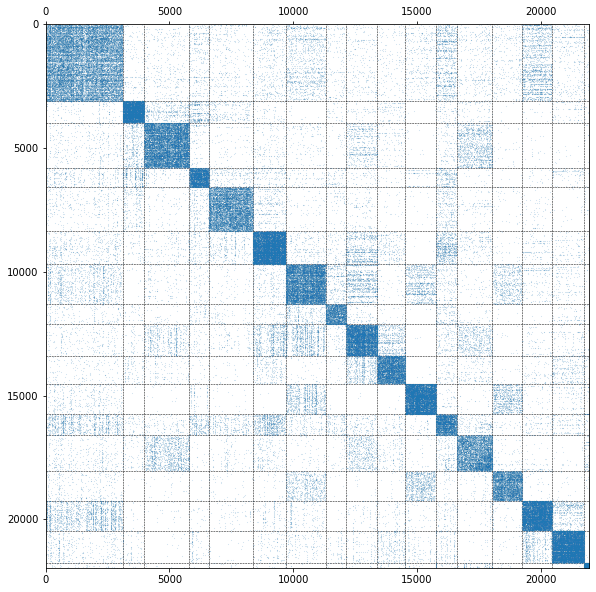

In [108]:
plt.figure(figsize=[10, 10])
z = np.argmax(Z_pred, 1)
o = np.argsort(z)
plot_sparse_clustered_adjacency(A, K, z, o, markersize=0.05)

In [109]:
print(Z_pred.sum(0))

[2529    0  876 1980  956 1945 1409 1781  989 1620 1413 1430 2059 2405
 2034 1560 1709  285]


In [110]:
density_baseline = A.nnz / (N**2 - N)
num_triangles = (A @ A @ A).diagonal().sum() / 6
num_possible_triangles = (N - 2) * (N - 1) * N / 6
clust_coef_baseline = num_triangles / num_possible_triangles
print(f'Background (over the entire graph):\n'
      f' - density    = {density_baseline:.3e}\n'
      f' - clust_coef = {clust_coef_baseline:.3e}')

Background (over the entire graph):
 - density    = 4.014e-04
 - clust_coef = 5.733e-08


In [112]:
import numpy as np


__all__ = [
    'evaluate_unsupervised',
    'clustering_coef',
    'coverage',
    'density',
    'conductance',
]


def evaluate_unsupervised(Z_pred, adj):
    return {'coverage': coverage(Z_pred, adj),
            'density': density(Z_pred, adj),
            'conductance': conductance(Z_pred, adj),
            'clustering_coef': clustering_coef(Z_pred, adj)}


def clustering_coef(Z_pred, adj):
    """Compute weighted average of clustering coefficients of communities."""
    def clustering_coef_community(ind, adj):
        """Compute clustering coefficient of a single community."""
        adj_com = adj[ind][:, ind]
        n = ind.sum()
        if n < 3:
            return 0
        # Number of possible triangles
        possible = (n - 2) * (n - 1) * n / 6
        # Number of existing triangles
        existing = (adj_com @ adj_com @ adj_com).diagonal().sum() / 6
        return existing / possible

    Z_pred = Z_pred.astype(bool)
    com_sizes = Z_pred.sum(0)
    clust_coefs = np.array([clustering_coef_community(Z_pred[:, c], adj) for c in range(Z_pred.shape[1])])
    return clust_coefs @ com_sizes / com_sizes.sum()


def coverage(Z_pred, adj):
    """What fraction of edges are explained by at least 1 community?

    Args:
        Z_pred: Binary community affiliation matrix
        adj : Unweighted symmetric adjacency matrix of a graph.
    """
    u, v = adj.nonzero()
    return ((Z_pred[u] * Z_pred[v]).sum(1) > 0).sum() / adj.nnz


def density(Z_pred, adj):
    """Average density of communities (weighted by size).

    Higher is better.

        (\sum_i density(C_i) * |C_i|) / (\sum_j |C_j|)

    Args:
        Z_pred: Binary community affiliation matrix
        adj : Unweighted symmetric adjacency matrix of a graph.
    """
    def density_community(ind, adj):
        ind = ind.astype(bool)
        n = ind.sum()
        if n  < 2:
            return 0.0
        else:
            return adj[ind][:, ind].nnz / (n**2 - n)
    Z_pred = Z_pred.astype(bool)
    com_sizes = Z_pred.sum(0) / Z_pred.sum()
    densities = np.array([density_community(Z_pred[:, c], adj) for c in range(Z_pred.shape[1])])
    return densities @ com_sizes


def conductance(Z_pred, adj):
    """Compute weight average of conductances of communities.

    Conductance of each community is weighted by its size.

        (\sum_i conductance(C_i) * |C_i|) / (\sum_j |C_j|)

    Args:
        Z_pred: Binary community affiliation matrix
        adj : Unweighted symmetric adjacency matrix of a graph.
    """
    def conductance_community(ind, adj):
        """Compute conductance of a single community.

        Args:
            ind: Binary indicator vector for the community.
            adj: Adjacency matrix in scipy.sparse format.
        """
        ind = ind.astype(bool)
        inside = adj[ind, :][:, ind].nnz
        outside = adj[~ind, :][:, ind].nnz
        if inside + outside == 0:
            return 1
        return outside / (inside + outside)

    Z_pred = Z_pred.astype(bool)
    com_sizes = Z_pred.sum(0)
    conductances = np.array([conductance_community(Z_pred[:, c], adj) for c in range(Z_pred.shape[1])])
    return conductances @ com_sizes / com_sizes.sum()


In [113]:
metrics = evaluate_unsupervised(Z_gt, A)
print(f"Ground truth communities:\n"
      f" - coverage    = {metrics['coverage']:.4f}\n"
      f" - conductance = {metrics['conductance']:.4f}\n"
      f" - density     = {metrics['density']:.3e}\n"
      f" - clust_coef  = {metrics['clustering_coef']:.3e}")

Ground truth communities:
 - coverage    = 0.9588
 - conductance = 0.3392
 - density     = 3.853e-03
 - clust_coef  = 9.145e-06


In [114]:
metrics = evaluate_unsupervised(Z_pred, A)
print(f"Predicted communities:\n"
      f" - coverage    = {metrics['coverage']:.4f}\n"
      f" - conductance = {metrics['conductance']:.4f}\n"
      f" - density     = {metrics['density']:.3e}\n"
      f" - clust_coef  = {metrics['clustering_coef']:.3e}")

Predicted communities:
 - coverage    = 0.9242
 - conductance = 0.2413
 - density     = 4.645e-03
 - clust_coef  = 1.062e-05


In [36]:
import numpy as np
import torch

from copy import deepcopy


class ModelSaver:
    """In-memory saver for model parameters.

    Storing weights in memory is faster than saving to disk with torch.save.
    """
    def __init__(self, model):
        self.model = model

    def save(self):
        self.state_dict = deepcopy(self.model.state_dict())

    def restore(self):
        self.model.load_state_dict(self.state_dict)


class EarlyStopping:
    """Base class for an early stopping monitor that says when it's time to stop training.

    Examples
    --------
    early_stopping = EarlyStopping()
    for epoch in range(max_epochs):
        sess.run(train_op)  # perform training operation
        early_stopping.next_step()
        if early_stopping.should_stop():
            break
        if early_stopping.should_save():
            model_saver.save()  # save model weights

    """
    def __init__(self):
        pass

    def reset(self):
        """Reset the internal state."""
        raise NotImplementedError

    def next_step(self):
        """Should be called at every iteration."""
        raise NotImplementedError

    def should_save(self):
        """Says if it's time to save model weights."""
        raise NotImplementedError

    def should_stop(self):
        """Says if it's time to stop training."""
        raise NotImplementedError


class NoEarlyStopping(EarlyStopping):
    """No early stopping."""
    def __init__(self):
        super().__init__()
        pass

    def reset(self):
        pass

    def next_step(self):
        pass

    def should_stop(self):
        return False

    def should_save(self):
        return False


class NoImprovementStopping(EarlyStopping):
    """Stop training when the validation metric stops improving.

    Parameters
    ----------
    validation_fn : function
        Calling this function returns the current value of the validation metric.
    mode : {'min', 'max'}
        Should the validation metric be minimized or maximized?
    patience : int
        Number of iterations without improvement before stopping.
    tolerance : float
        Minimal improvement in validation metric to not trigger patience.
    relative : bool
        Is tolerance measured in absolute units or relatively?

    Attributes
    ----------
    _best_value : float
        Best value of the validation loss.
    _num_bad_epochs : int
        Number of epochs since last significant improvement in validation metric.
    _time_to_save : bool
        Is it time to save the model weights?
    _is_better : function
        Tells if new validation metric value is better than the best one so far.
        Signature self._is_better(new_value, best_value).

    """
    def __init__(self, validation_fn, mode='min', patience=10, tolerance=0.0, relative=False):
        super().__init__()
        self.validation_fn = validation_fn
        self.mode = mode
        self.patience = patience
        self.tolerance = tolerance
        self.relative = relative
        self.reset()

        if mode not in ['min', 'max']:
            raise ValueError(f"Mode should be either 'min' or 'max' (got {mode} instead).")

        # Create the comparison function
        if relative:
            if mode == 'min':
                self._is_better = lambda new, best: new < best - (best * tolerance)
            if mode == 'max':
                self._is_better = lambda new, best: new > best + (best * tolerance)
        else:
            if mode == 'min':
                self._is_better = lambda new, best: new < best - tolerance
            if mode == 'max':
                self._is_better = lambda new, best: new > best + tolerance

    def reset(self):
        """Reset the internal state."""
        self._best_value = self.validation_fn()
        self._num_bad_epochs = 0
        self._time_to_save = False

    def next_step(self):
        """Should be called at every iteration."""
        last_value = self.validation_fn()
        if self._is_better(last_value, self._best_value):
            self._time_to_save = True
            self._best_value = last_value
            self._num_bad_epochs = 0
        else:
            self._num_bad_epochs += 1

    def should_save(self):
        """Says if it's time to save model weights."""
        if self._time_to_save:
            self._time_to_save = False
            return True
        else:
            return False

    def should_stop(self):
        """Says if it's time to stop training."""
        return self._num_bad_epochs > self.patience

In [26]:
import numpy as np
import scipy.sparse as sp
import torch
import torch.utils.data as data_utils


class EdgeSampler(data_utils.Dataset):
    """Sample edges and non-edges uniformly from a graph.

    Args:
        A: adjacency matrix.
        num_pos: number of edges per batch.
        num_neg: number of non-edges per batch.
    """
    def __init__(self, A, num_pos=1000, num_neg=1000):
        self.num_pos = num_pos
        self.num_neg = num_neg
        self.A = A
        self.edges = np.transpose(A.nonzero())
        self.num_nodes = A.shape[0]
        self.num_edges = self.edges.shape[0]

    def __getitem__(self, key):
        np.random.seed(key)
        edges_idx = np.random.randint(0, self.num_edges, size=self.num_pos, dtype=np.int64)
        next_edges = self.edges[edges_idx, :]

        # Select num_neg non-edges
        generated = False
        while not generated:
            candidate_ne = np.random.randint(0, self.num_nodes, size=(2*self.num_neg, 2), dtype=np.int64)
            cne1, cne2 = candidate_ne[:, 0], candidate_ne[:, 1]
            to_keep = (1 - self.A[cne1, cne2]).astype(np.bool).A1 * (cne1 != cne2)
            next_nonedges = candidate_ne[to_keep][:self.num_neg]
            generated = to_keep.sum() >= self.num_neg
        return torch.LongTensor(next_edges), torch.LongTensor(next_nonedges)

    def __len__(self):
        return 2**32

def collate_fn(batch):
    edges, nonedges = batch[0]
    return (edges, nonedges)

def get_edge_sampler(A, num_pos=1000, num_neg=1000, num_workers=2):
    data_source = EdgeSampler(A, num_pos, num_neg)
    return data_utils.DataLoader(data_source, num_workers=num_workers, collate_fn=collate_fn)


In [80]:
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F

#from nocd.utils import to_sparse_tensor

__all__ = [
    'GCN',
    'GraphConvolution',
]


def sparse_or_dense_dropout(x, p=0.5, training=True):
    if isinstance(x, (torch.sparse.FloatTensor, torch.sparse.FloatTensor)):
        new_values = F.dropout(x.values(), p=p, training=training)
        return torch.sparse.FloatTensor(x.indices(), new_values, x.size())
    else:
        return F.dropout(x, p=p, training=training)


class GraphConvolution(nn.Module):
    """Graph convolution layer.

    Args:
        in_features: Size of each input sample.
        out_features: Size of each output sample.

    """
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.empty(in_features, out_features))
        self.bias = nn.Parameter(torch.empty(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x, adj):
        return adj @ (x @ self.weight) + self.bias


class GCN(nn.Module):
    """Graph convolution network.

    References:
        "Semi-superivsed learning with graph convolutional networks",
        Kipf and Welling, ICLR 2017
    """
    def __init__(self, input_dim, hidden_dims, output_dim, dropout=0.5, batch_norm=False):
        super().__init__()
        self.dropout = dropout
        layer_dims = np.concatenate([hidden_dims, [output_dim]]).astype(np.int32)
        self.layers = nn.ModuleList([GraphConvolution(input_dim, layer_dims[0])])
        for idx in range(len(layer_dims) - 1):
            self.layers.append(GraphConvolution(layer_dims[idx], layer_dims[idx + 1]))
        if batch_norm:
            self.batch_norm = [
                nn.BatchNorm1d(dim, affine=False, track_running_stats=False) for dim in hidden_dims
            ]
        else:
            self.batch_norm = None

    @staticmethod
    def normalize_adj(adj : sp.csr_matrix):
        """Normalize adjacency matrix and convert it to a sparse tensor."""
        if sp.isspmatrix(adj):
            adj = adj.tolil()
            adj.setdiag(1)
            adj = adj.tocsr()
            deg = np.ravel(adj.sum(1))
            deg_sqrt_inv = 1 / np.sqrt(deg)
            adj_norm = adj.multiply(deg_sqrt_inv[:, None]).multiply(deg_sqrt_inv[None, :])
        elif torch.is_tensor(adj):
            deg = adj.sum(1)
            deg_sqrt_inv = 1 / torch.sqrt(deg)
            adj_norm = adj * deg_sqrt_inv[:, None] * deg_sqrt_inv[None, :]
        return adj_norm

    def forward(self, x, adj):
        for idx, gcn in enumerate(self.layers):
            if self.dropout != 0:
                x = sparse_or_dense_dropout(x, p=self.dropout, training=self.training)
            x = gcn(x, adj)
            if idx != len(self.layers) - 1:
                x = F.relu(x)
                if self.batch_norm is not None:
                    x = self.batch_norm[idx](x)
        return x

    def get_weights(self):
        """Return the weight matrices of the model."""
        return [w for n, w in self.named_parameters() if 'bias' not in n]

    def get_biases(self):
        """Return the bias vectors of the model."""
        return [w for n, w in self.named_parameters() if 'bias' in n]


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scipy.sparse as sp
#from utils import to_sparse_tensor, sparse_or_dense_dropout
#from layers import GraphConvolution


class GCN(nn.Module):
    """Graph convolution network.

    References:
        "Semi-superivsed learning with graph convolutional networks",
        Kipf and Welling, ICLR 2017
    """
    def __init__(self, input_dim, hidden_dims, output_dim, dropout=0.5, batch_norm=False):
        super().__init__()
        self.dropout = dropout
        layer_dims = np.concatenate([hidden_dims, [output_dim]]).astype(np.int32)
        self.layers = nn.ModuleList([GraphConvolution(input_dim, layer_dims[0])])
        for idx in range(len(layer_dims) - 1):
            self.layers.append(GraphConvolution(layer_dims[idx], layer_dims[idx + 1]))
        if batch_norm:
            self.batch_norm = [
                nn.BatchNorm1d(dim, affine=False, track_running_stats=False) for dim in hidden_dims
            ]
        else:
            self.batch_norm = None

    @staticmethod
    def normalize_adj(adj : sp.csr_matrix):
        """Normalize adjacency matrix and convert it to a sparse tensor."""
        if sp.isspmatrix(adj):
            adj = adj.tolil()
            adj.setdiag(1)
            adj = adj.tocsr()
            deg = np.ravel(adj.sum(1))
            deg_sqrt_inv = 1 / np.sqrt(deg)
            adj_norm = adj.multiply(deg_sqrt_inv[:, None]).multiply(deg_sqrt_inv[None, :])
        elif torch.is_tensor(adj):
            deg = adj.sum(1)
            deg_sqrt_inv = 1 / torch.sqrt(deg)
            adj_norm = adj * deg_sqrt_inv[:, None] * deg_sqrt_inv[None, :]
        return to_sparse_tensor(adj_norm)

    def forward(self, x, adj):
        for idx, gcn in enumerate(self.layers):
            if self.dropout != 0:
                x = sparse_or_dense_dropout(x, p=self.dropout, training=self.training)
            x = gcn(x, adj)
            if idx != len(self.layers) - 1:
                x = F.relu(x)
                if self.batch_norm is not None:
                    x = self.batch_norm[idx](x)
        return x

    def get_weights(self):
        """Return the weight matrices of the model."""
        return [w for n, w in self.named_parameters() if 'bias' not in n]

    def get_biases(self):
        """Return the bias vectors of the model."""
        return [w for n, w in self.named_parameters() if 'bias' in n]


In [ ]:
device = 'cpu'
hidden_sizes = [128]    # hidden sizes of the GNN
weight_decay = 1e-2     # strength of L2 regularization on GNN weights
dropout = 0.5           # whether to use dropout
batch_norm = True       # whether to use batch norm
lr = 1e-3               # learning rate
max_epochs = 500        # number of epochs to train
display_step = 25       # how often to compute validation loss
balance_loss = True     # whether to use balanced loss
stochastic_loss = True  # whether to use stochastic or full-batch training
batch_size = 20000   

In [ ]:
x_norm = normalize(X)  # node features
# x_norm = normalize(A)  # adjacency matrix
# x_norm = sp.hstack([normalize(X), normalize(A)])  # concatenate A and X
#x_norm = nocd.utils.to_sparse_tensor(x_norm).cuda()

In [ ]:
x_norm = to_sparse_tensor(x_norm).cuda()

AttributeError: ignored

In [ ]:
type(x_norm)

tensorflow.python.framework.sparse_tensor.SparseTensor

In [ ]:
sampler = get_edge_sampler(A, batch_size, batch_size, num_workers=5)

# adj_norm = gnn.normalize_adj(A)
# decoder = nocd.nn.BerpoDecoder(N, A.nnz, balance_loss=balance_loss)
# opt = torch.optim.Adam(gnn.parameters(), lr=lr)

In [ ]:
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F

#from nocd.utils import to_sparse_tensor

__all__ = [
    'GCN',
    'GraphConvolution',
]


def sparse_or_dense_dropout(x, p=0.5, training=True):
    if isinstance(x, (torch.sparse.FloatTensor, torch.cuda.sparse.FloatTensor)):
        new_values = F.dropout(x.values(), p=p, training=training)
        return torch.sparse.FloatTensor(x.indices(), new_values, x.size())
    else:
        return F.dropout(x, p=p, training=training)


class GraphConvolution(nn.Module):
    """Graph convolution layer.

    Args:
        in_features: Size of each input sample.
        out_features: Size of each output sample.

    """
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.empty(in_features, out_features))
        self.bias = nn.Parameter(torch.empty(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x, adj):
        return adj @ (x @ self.weight) + self.bias


class GCN(nn.Module):
    """Graph convolution network.

    References:
        "Semi-superivsed learning with graph convolutional networks",
        Kipf and Welling, ICLR 2017
    """
    def __init__(self, input_dim, hidden_dims, output_dim, dropout=0.5, batch_norm=False):
        super().__init__()
        self.dropout = dropout
        layer_dims = np.concatenate([hidden_dims, [output_dim]]).astype(np.int32)
        self.layers = nn.ModuleList([GraphConvolution(input_dim, layer_dims[0])])
        for idx in range(len(layer_dims) - 1):
            self.layers.append(GraphConvolution(layer_dims[idx], layer_dims[idx + 1]))
        if batch_norm:
            self.batch_norm = [
                nn.BatchNorm1d(dim, affine=False, track_running_stats=False) for dim in hidden_dims
            ]
        else:
            self.batch_norm = None

    @staticmethod
    def normalize_adj(adj : sp.csr_matrix):
        """Normalize adjacency matrix and convert it to a sparse tensor."""
        if sp.isspmatrix(adj):
            adj = adj.tolil()
            adj.setdiag(1)
            adj = adj.tocsr()
            deg = np.ravel(adj.sum(1))
            deg_sqrt_inv = 1 / np.sqrt(deg)
            adj_norm = adj.multiply(deg_sqrt_inv[:, None]).multiply(deg_sqrt_inv[None, :])
        elif torch.is_tensor(adj):
            deg = adj.sum(1)
            deg_sqrt_inv = 1 / torch.sqrt(deg)
            adj_norm = adj * deg_sqrt_inv[:, None] * deg_sqrt_inv[None, :]
        return to_sparse_tensor(adj_norm)

    def forward(self, x, adj):
        for idx, gcn in enumerate(self.layers):
            if self.dropout != 0:
                x = sparse_or_dense_dropout(x, p=self.dropout, training=self.training)
            x = gcn(x, adj)
            if idx != len(self.layers) - 1:
                x = F.relu(x)
                if self.batch_norm is not None:
                    x = self.batch_norm[idx](x)
        return x

    def get_weights(self):
        """Return the weight matrices of the model."""
        return [w for n, w in self.named_parameters() if 'bias' not in n]

    def get_biases(self):
        """Return the bias vectors of the model."""
        return [w for n, w in self.named_parameters() if 'bias' in n]


In [ ]:
hidden_sizes = [128]    # hidden sizes of the GNN
weight_decay = 1e-2     # strength of L2 regularization on GNN weights
dropout = 0.5           # whether to use dropout
batch_norm = True       # whether to use batch norm
lr = 1e-3               # learning rate
max_epochs = 500        # number of epochs to train
display_step = 25       # how often to compute validation loss
balance_loss = True     # whether to use balanced loss
stochastic_loss = True  # whether to use stochastic or full-batch training
batch_size = 20000      # batch size (only for stochastic training)

In [ ]:
gnn = GCN(x_norm.shape[1], hidden_sizes, K, batch_norm=batch_norm, dropout=dropout)

In [ ]:
adj_norm = gnn.normalize_adj(A)


In [31]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as td


__all__ = [
    'BerpoDecoder',
]


class BernoulliDecoder(nn.Module):
    def __init__(self, num_nodes, num_edges, balance_loss=False):
        """Base class for Bernoulli decoder.

        Args:
            num_nodes: Number of nodes in a graph.
            num_edges: Number of edges in a graph.
            balance_loss: Whether to balance contribution from edges and non-edges.
        """
        super().__init__()
        self.num_nodes = num_nodes
        self.num_edges = num_edges
        self.num_possible_edges = num_nodes**2 - num_nodes
        self.num_nonedges = self.num_possible_edges - self.num_edges
        self.balance_loss = balance_loss

    def forward_batch(self, emb, idx):
        """Compute probabilities of given edges.

        Args:
            emb: embedding matrix, shape (num_nodes, emb_dim)
            idx: edge indices, shape (batch_size, 2)

        Returns:
            edge_probs: Bernoulli distribution for given edges, shape (batch_size)
        """
        raise NotImplementedError

    def forward_full(self, emb):
        """Compute probabilities for all edges.

        Args:
            emb: embedding matrix, shape (num_nodes, emb_dim)

        Returns:
            edge_probs: Bernoulli distribution for all edges, shape (num_nodes, num_nodes)
        """
        raise NotImplementedError

    def loss_batch(self, emb, ones_idx, zeros_idx):
        """Compute loss for given edges and non-edges."""
        raise NotImplementedError

    def loss_full(self, emb, adj):
        """Compute loss for all edges and non-edges."""
        raise NotImplementedError


class BerpoDecoder(BernoulliDecoder):
    def __init__(self, num_nodes, num_edges, balance_loss=False):
        super().__init__(num_nodes, num_edges, balance_loss)
        edge_proba = num_edges / (num_nodes**2 - num_nodes)
        self.eps = -np.log(1 - edge_proba)

    def forward_batch(self, emb, idx):
        """Compute probabilities of given edges.

        Args:
            emb: embedding matrix, shape (num_nodes, emb_dim)
            idx: edge indices, shape (batch_size, 2)

        Returns:
            edge_probs: Bernoulli distribution for given edges, shape (batch_size)
        """
        e1, e2 = idx.t()
        logits = torch.sum(emb[e1] * emb[e2], dim=1)
        logits += self.eps
        probs = 1 - torch.exp(-logits)
        return td.Bernoulli(probs=probs)

    def forward_full(self, emb):
        """Compute probabilities for all edges.

        Args:
            emb: embedding matrix, shape (num_nodes, emb_dim)

        Returns:
            edge_probs: Bernoulli distribution for all edges, shape (num_nodes, num_nodes)
        """
        logits = emb @ emb.t()
        logits += self.eps
        probs = 1 - torch.exp(-logits)
        return td.Bernoulli(probs=probs)

    def loss_batch(self, emb, ones_idx, zeros_idx):
        """Compute BerPo loss for a batch of edges and non-edges."""
        # Loss for edges
        e1, e2 = ones_idx[:, 0], ones_idx[:, 1]
        edge_dots = torch.sum(emb[e1] * emb[e2], dim=1)
        loss_edges = -torch.mean(torch.log(-torch.expm1(-self.eps - edge_dots)))

        # Loss for non-edges
        ne1, ne2 = zeros_idx[:, 0], zeros_idx[:, 1]
        loss_nonedges = torch.mean(torch.sum(emb[ne1] * emb[ne2], dim=1))
        if self.balance_loss:
            neg_scale = 1.0
        else:
            neg_scale = self.num_nonedges / self.num_edges
        return (loss_edges + neg_scale * loss_nonedges) / (1 + neg_scale)

    def loss_full(self, emb, adj):
        """Compute BerPo loss for all edges & non-edges in a graph."""
        e1, e2 = adj.nonzero()
        edge_dots = torch.sum(emb[e1] * emb[e2], dim=1)
        loss_edges = -torch.sum(torch.log(-torch.expm1(-self.eps - edge_dots)))

        # Correct for overcounting F_u * F_v for edges and nodes with themselves
        self_dots_sum = torch.sum(emb * emb)
        correction = self_dots_sum + torch.sum(edge_dots)
        sum_emb = torch.sum(emb, dim=0, keepdim=True).t()
        loss_nonedges = torch.sum(emb @ sum_emb) - correction

        if self.balance_loss:
            neg_scale = 1.0
        else:
            neg_scale = self.num_nonedges / self.num_edges
        return (loss_edges / self.num_edges + neg_scale * loss_nonedges / self.num_nonedges) / (1 + neg_scale)

In [ ]:
decoder = BerpoDecoder(N, A.nnz, balance_loss=balance_loss)


In [ ]:
opt = torch.optim.Adam(gnn.parameters(), lr=lr)

In [ ]:
def get_nmi(thresh=0.5):
    """Compute Overlapping NMI of the communities predicted by the GNN."""
    gnn.eval()
    Z = F.relu(gnn(x_norm, adj_norm))
    Z_pred = Z.cpu().detach().numpy() > thresh
    nmi = nocd.metrics.overlapping_nmi(Z_pred, Z_gt)
    return nmi

In [ ]:
val_loss = np.inf
validation_fn = lambda: val_loss
early_stopping = nocd.train.NoImprovementStopping(validation_fn, patience=10)
model_saver = nocd.train.ModelSaver(gnn)

for epoch, batch in enumerate(sampler):
    if epoch > max_epochs:
        break
    if epoch % 25 == 0:
        with torch.no_grad():
            gnn.eval()
            # Compute validation loss
            Z = F.relu(gnn(x_norm, adj_norm))
            val_loss = decoder.loss_full(Z, A)
            print(f'Epoch {epoch:4d}, loss.full = {val_loss:.4f}, nmi = {get_nmi():.2f}')
            
            # Check if it's time for early stopping / to save the model
            early_stopping.next_step()
            if early_stopping.should_save():
                model_saver.save()
            if early_stopping.should_stop():
                print(f'Breaking due to early stopping at epoch {epoch}')
                break
            
    # Training step
    gnn.train()
    opt.zero_grad()
    Z = F.relu(gnn(x_norm, adj_norm))
    ones_idx, zeros_idx = batch
    if stochastic_loss:
        loss = decoder.loss_batch(Z, ones_idx, zeros_idx)
    else:
        loss = decoder.loss_full(Z, A)
    loss += nocd.utils.l2_reg_loss(gnn, scale=weight_decay)
    loss.backward()
    opt.step()

AttributeError: ignored